In [2]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from itertools import islice

In [3]:
n_movie_clusters = 5
rating_multiplier = 5
year_multiplier = 0.05
test_sample_size = 100_000

weight_genre, weight_cluster, weight_movie = 0.35, 0.45, 0.2

In [4]:
def custom_mse_scorer(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def custom_mae_scorer(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

def custom_accuracy_scorer(y_true, y_pred, tol=(1.0 + 1e-9)):
    accuracy = np.isclose(y_pred, y_true, atol=tol).mean()
    return accuracy

In [15]:
class GenreBasedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, movies_hot_df):
        self.user_genre_df = None
        self.movies_hot_df = movies_hot_df
        
    def fit(self, X, y=None):
        ratings_train_df = pd.concat([X, y], axis=1)
        self.user_genre_df = pd.DataFrame({"userId": ratings_train_df["userId"].unique()})
        genres = self.movies_hot_df["Genres_Split"].explode().unique()
        
        for genre in genres:
            self.user_genre_df[genre] = pd.Series(np.zeros(self.user_genre_df.shape[0]))
            self.user_genre_df["count_"+genre] = pd.Series(np.zeros(self.user_genre_df.shape[0]))
        
        self.user_genre_df.set_index("userId", inplace=True)
        
        movies_exploded_df = self.movies_hot_df[["Genres_Split"]].explode('Genres_Split').rename(columns={'Genres_Split': 'genre'})
        merged_df = ratings_train_df.merge(movies_exploded_df, on='movieId')
        
        agg_df = merged_df.groupby(['userId', 'genre']).agg(
            total_rating=('rating', 'sum'),
            count=('rating', 'count')
        ).reset_index()
        
        agg_df['average_rating'] = agg_df['total_rating'] / agg_df['count']
        
        self.user_genre_df = agg_df.pivot(index='userId', columns='genre', values=['average_rating', 'count'])
        self.user_genre_df.columns = [f'{stat}_{genre}' for stat, genre in self.user_genre_df.columns]
        self.user_genre_df = self.user_genre_df.reset_index()
        self.user_genre_df.fillna(3.5, inplace=True)
        self.user_genre_df.drop(["count_"+col for col in genres], axis=1, inplace=True)
        self.user_genre_df.set_index("userId", inplace=True)
        
        return self
        
    def predict(self, X, rounded=True, default=3.5):
        y_pred = []
        for i, row in X.iterrows():
            y_pred.append(self._predict(row["userId"], row["movieId"], rounded, default))
        return y_pred
        
    def _predict(self, user_id, movie_id, rounded=True, default=3.5):
        if user_id not in self.user_genre_df.index or movie_id not in self.movies_hot_df.index:
            return default
        
        movie_genres = self.movies_hot_df.loc[movie_id]["Genres_Split"]
        movie_genres = ["average_rating_"+x for x in movie_genres]
        res = self.user_genre_df.loc[user_id][movie_genres].mean()
        return round(res * 2) / 2 if rounded else res
        
       
class ClusterBasedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, movies_hot_df):
        self.users_df = None
        self.movies_hot_df = movies_hot_df.copy()
        
    def fit(self, X, y=None):
        ratings_train_df = pd.concat([X, y], axis=1)
        
        self.movies_hot_df["rating_mean"] *= rating_multiplier
        self.movies_hot_df['year'] *= year_multiplier
        
        kmeans = KMeans(n_clusters=n_movie_clusters, random_state=42)
        self.movies_hot_df['Cluster'] = kmeans.fit_predict(self.movies_hot_df.drop(["Genres_Split"], axis=1))
        
        self.movies_hot_df["rating_mean"] /= rating_multiplier
        
        ratings_with_clusters = ratings_train_df.merge(self.movies_hot_df, left_on='movieId', right_index=True)
        
        user_cluster_stats = ratings_with_clusters.groupby(['userId', 'Cluster'])['rating'].agg(['count', 'sum']).reset_index()
        user_cluster_pivot = user_cluster_stats.pivot(index='userId', columns='Cluster', values=['count', 'sum']).fillna(0)
        user_cluster_pivot.columns = [f'Cluster_{stat}_{cluster}' for stat, cluster in user_cluster_pivot.columns]
        
        for cluster in range(n_movie_clusters):
            count_col = f'Cluster_count_{cluster}'
            sum_col = f'Cluster_sum_{cluster}'
            mean_col = f'Cluster_mean_{cluster}'
            if count_col in user_cluster_pivot.columns and sum_col in user_cluster_pivot.columns:
                user_cluster_pivot[mean_col] = user_cluster_pivot[sum_col] / user_cluster_pivot[count_col]
            else:
                user_cluster_pivot[count_col] = 0
                user_cluster_pivot[sum_col] = 0
                user_cluster_pivot[mean_col] = 0
        
        user_cluster_pivot = user_cluster_pivot.fillna(0)
        self.users_df = user_cluster_pivot.reset_index()
        self.users_df.set_index("userId", inplace=True)
        
        sum_sums = self.users_df[["Cluster_sum_"+str(x) for x in range(n_movie_clusters)]].sum(axis=1)
        count_sums = self.users_df[["Cluster_count_"+str(x) for x in range(n_movie_clusters)]].sum(axis=1)
        self.users_df["rating_mean"] = sum_sums / count_sums
        
        return self
        
    def predict(self, X, rounded=True):
        y_pred = []
        for i, row in X.iterrows():
            y_pred.append(self._predict(row["userId"], row["movieId"], rounded))
        return y_pred
        
    def _predict(self, user_id, movie_id, rounded=True):
        if user_id not in self.users_df.index or movie_id not in self.movies_hot_df.index:
            return 3.5
        
        cluster = int(self.movies_hot_df.loc[movie_id]["Cluster"])
        user_pred = self.users_df.loc[user_id][f"Cluster_mean_{cluster}"]
        return round(user_pred * 2) / 2 if rounded else user_pred
        
        
class MovieBasedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.movie_ratings = None
        
    def fit(self, X, y=None):
        self.movie_ratings = X["rating_mean"]
        return self
        
    def predict(self, X, rounded=True):
        y_pred = []
        for i, row in X.iterrows():
            y_pred.append(self._predict(row["userId"], row["movieId"], rounded))
        return y_pred
        
    def _predict(self, user_id, movie_id, rounded=True):
        if movie_id not in self.movie_ratings.index:
            return 3.5
        
        film_pred = self.movie_ratings.loc[movie_id]
        return round(film_pred * 2) / 2 if rounded else film_pred
    
    
class HybridRegressor(BaseEstimator, RegressorMixin):
    def __init__(
            self, 
            movies_hot_df,
            weights = (0.35, 0.45, 0.2),
            genre_based_regressor: GenreBasedRegressor = None,
            cluster_based_regressor: ClusterBasedRegressor = None,
            movie_based_regressor: MovieBasedRegressor = None):  
        self.movies_hot_df = movies_hot_df
        self.weights = weights
        self.genre_based_regressor = (
            genre_based_regressor 
            if genre_based_regressor is not None 
            else GenreBasedRegressor(movies_hot_df)
        )
        self.cluster_based_regressor = (
            cluster_based_regressor 
            if cluster_based_regressor is not None 
            else ClusterBasedRegressor(movies_hot_df)
        )
        self.movie_based_regressor = (
            movie_based_regressor 
            if movie_based_regressor is not None 
            else MovieBasedRegressor()
        )
        
    def fit(self, X, y=None):
        self.genre_based_regressor = self.genre_based_regressor.fit(X, y)
        self.cluster_based_regressor = self.cluster_based_regressor.fit(X, y)
        self.movie_based_regressor = self.movie_based_regressor.fit(movies_hot_df)
        return self
        
    def predict(self, X, rounded=True):
        genre_predictions = self.genre_based_regressor.predict(X, False)
        cluster_predictions = self.cluster_based_regressor.predict(X, False)
        movie_predictions = self.movie_based_regressor.predict(X, False)
        
        y_pred = np.array([
            np.array([genre_pred, cluster_pred, movie_pred]).dot(np.array(self.weights))
            for genre_pred, cluster_pred, movie_pred 
            in zip(genre_predictions, cluster_predictions, movie_predictions)
        ])
        return np.round(y_pred * 2) / 2 if rounded else y_pred
        

class PreProcessingBase(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):   
        X = X.copy()
        X['Genres_Split'] = X['genres'].apply(lambda x: x.split('|'))
        mlb = MultiLabelBinarizer()
        binary_matrix = mlb.fit_transform(X['Genres_Split'])
        binary_df = pd.DataFrame(binary_matrix, columns=mlb.classes_)
        movies_hot_df = pd.concat([X.reset_index(), binary_df], axis=1).set_index("movieId")
        return movies_hot_df.drop(["title", "genres"], axis=1)
    
    
class PreProcessingAggregated(PreProcessingBase):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        movies_df, ratings_train_df = X
        movies_hot_df = super().transform(movies_df)
        
        movies_df = movies_df.copy()
        movies_hot_df = movies_hot_df.merge(ratings_train_df.groupby("movieId")["rating"].mean().reset_index(), on="movieId")
        movies_hot_df.rename(columns={"rating": "rating_mean"}, inplace=True)
        movies_hot_df = movies_hot_df.set_index("movieId")
        
        movies_hot_year_df = movies_hot_df.copy()
        movies_df.reset_index(inplace=True)
        years = movies_df[movies_df['movieId'].isin(movies_hot_df.index)]['title'].str.extract(r'\((\d{4})\)')
        years.index = movies_hot_year_df.index
        years[0] = pd.to_numeric(years[0], errors='coerce')
        movies_hot_df['year'] = years.fillna(years.median())
        
        return movies_hot_df

In [16]:
ratings_df = pd.read_csv("data/ratings.csv")
movies_df = pd.read_csv("data/movies.csv", index_col="movieId")

X = ratings_df.drop(["rating"], axis=1)
y = ratings_df["rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
ratings_train_df = pd.concat([X_train, y_train], axis=1)
ratings_test_df = pd.concat([X_test, y_test], axis=1)

In [17]:
movies_hot_df = PreProcessingAggregated().transform((movies_df, ratings_train_df))

In [19]:
hybrid_regressor = HybridRegressor(
    movies_hot_df).fit(X_train, y_train)

x_test_sample = ratings_test_df.sample(frac=1, random_state=42)
x_test_sample = x_test_sample[:test_sample_size]
y_true = x_test_sample["rating"].values

hybrid_predictions = hybrid_regressor.predict(x_test_sample, False)
print_stats(get_performance_stats(y_true, hybrid_predictions))

C:\Users\Василий\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


MSE: 0.757
MAE: 0.667
ACCURACY: 0.778


In [ ]:
genre_based_regressor = GenreBasedRegressor(movies_hot_df).fit(X_train, y_train)

In [ ]:
cluster_based_regressor = ClusterBasedRegressor(movies_hot_df).fit(X_train, y_train)

In [ ]:
movie_based_regressor = MovieBasedRegressor().fit(movies_hot_df)

In [8]:
def get_performance_stats(y_true, y_pred):
    mse = custom_mse_scorer(np.array(y_pred), np.array(y_true))
    mae = custom_mae_scorer(np.array(y_pred), np.array(y_true))
    acc = custom_accuracy_scorer(np.array(y_pred), np.array(y_true))
    
    return {"mse": mse, "mae": mae, "accuracy": acc}

def print_stats(stats):
    for key, value in stats.items():
        print(key.upper() + ": " + str(round(value, 3)))

In [ ]:
x_test_sample = ratings_test_df.sample(frac=1, random_state=42)
x_test_sample = x_test_sample[:test_sample_size]
y_true = x_test_sample["rating"].values

genre_predictions = genre_based_regressor.predict(x_test_sample, False)
print_stats(get_performance_stats(y_true, genre_predictions))

In [ ]:
cluster_predictions = cluster_based_regressor.predict(x_test_sample, False)
print_stats(get_performance_stats(y_true, cluster_predictions))

In [ ]:
movie_predictions = movie_based_regressor.predict(x_test_sample, False)
print_stats(get_performance_stats(y_true, cluster_predictions))

In [ ]:
weights = np.array([weight_genre, weight_cluster, weight_movie])
y_pred = np.array([
    np.array([genre_pred, cluster_pred, movie_pred]).dot(weights)
    for genre_pred, cluster_pred, movie_pred 
    in zip(genre_predictions, cluster_predictions, movie_predictions)
])

print_stats(get_performance_stats(y_true, y_pred))

# Testing

In [ ]:
# ratings_df = pd.read_csv("data/ratings.csv")
# movies_df = pd.read_csv("data/movies.csv", index_col="movieId")
# 
# X = ratings_df.drop(["rating"], axis=1)
# y = ratings_df["rating"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
# ratings_train_df = pd.concat([X_train, y_train], axis=1)
# ratings_test_df = pd.concat([X_test, y_test], axis=1)
# 
# 
# movies_df['Genres_Split'] = movies_df['genres'].apply(lambda x: x.split('|'))
# mlb = MultiLabelBinarizer()
# binary_matrix = mlb.fit_transform(movies_df['Genres_Split'])
# binary_df = pd.DataFrame(binary_matrix, columns=mlb.classes_)
# movies_hot_df = movies_df.join(binary_df)

In [ ]:
movie_genres = movies_hot_df.loc[X["movieId"]]["Genres_Split"]
print(type(movie_genres))

In [ ]:
movie_genres = movie_genres.apply(lambda cell: ["average_rating_"+x for x in cell])
movie_genres.head()

In [ ]:
X

In [ ]:
genre_based_regressor.user_genre_df

In [ ]:
X["userId"].apply(lambda x: (x in genre_based_regressor.user_genre_df.index.values))

In [ ]:
res = genre_based_regressor.user_genre_df.loc[X["userId"]][movie_genres].mean()

# Hand clustering by genre

In [ ]:
user_genre_df = pd.DataFrame({"userId": ratings_train_df["userId"].unique()})
genres = movies_hot_df["Genres_Split"].explode().unique()

for genre in genres:
    user_genre_df[genre] = pd.Series(np.zeros(user_genre_df.shape[0]))
    user_genre_df["count_"+genre] = pd.Series(np.zeros(user_genre_df.shape[0]))

user_genre_df.set_index("userId", inplace=True)

movies_df = movies_df.explode('Genres_Split').rename(columns={'Genres_Split': 'genre'})
merged_df = ratings_train_df.merge(movies_df, on='movieId')

agg_df = merged_df.groupby(['userId', 'genre']).agg(
    total_rating=('rating', 'sum'),
    count=('rating', 'count')
).reset_index()

agg_df['average_rating'] = agg_df['total_rating'] / agg_df['count']

user_genre_df = agg_df.pivot(index='userId', columns='genre', values=['average_rating', 'count'])
user_genre_df.columns = [f'{stat}_{genre}' for stat, genre in user_genre_df.columns]
user_genre_df = user_genre_df.reset_index()
user_genre_df.fillna(3.5, inplace=True)
user_genre_df.drop(["count_"+col for col in genres], axis=1, inplace=True)
user_genre_df.set_index("userId", inplace=True)

In [ ]:
x_test_sample = ratings_test_df.sample(frac=1, random_state=42)
y_true = x_test_sample["rating"].values[:100_000]

genre_prediction_arr = genre_prediction(x_test_sample[:100_000])

mse = custom_mse_scorer(np.array(genre_prediction_arr), np.array(y_true))
mae = custom_mae_scorer(np.array(genre_prediction_arr), np.array(y_true))
print("MSE:", mse)
print("MAE:", mae)

In [ ]:
# weight_combinations = []
# coefs = [x/20 for x in range(0, 21)]
# for coef_a in coefs:
#     for coef_b in coefs:
#         if coef_a + coef_b  > 1:
#             continue
#         coef_c = 1 - coef_a - coef_b
#         weight_combinations.append((coef_a, coef_b, coef_c))

# Clustering stuff

In [ ]:
movies_hot_df

In [ ]:
movies_hot_df.isna().sum()

In [ ]:
movies_hot_df

In [ ]:
movies_hot_df.isna().sum()

In [ ]:
# movies_hot_df, users_df = None, None
# 
# # for n_movie_clusters in range(2, 11):
# #     for rating_multiplier in range(1, 6):
# #         for year_multiplier in range(5, 26, 5):
# #             year_multiplier = 1 / year_multiplier
# 
# ratings_df = pd.read_csv("data/ratings.csv")
# movies_df = pd.read_csv("data/movies.csv", index_col="movieId")
# 
# X = ratings_df.drop(["rating"], axis=1)
# y = ratings_df["rating"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
# 
# ratings_train_df = pd.concat([X_train, y_train], axis=1)
# ratings_test_df = pd.concat([X_test, y_test], axis=1)
# 
# 
# 
# 
# movies_df['Genres_Split'] = movies_df['genres'].apply(lambda x: x.split('|'))
# mlb = MultiLabelBinarizer()
# binary_matrix = mlb.fit_transform(movies_df['Genres_Split'])
# binary_df = pd.DataFrame(binary_matrix, columns=mlb.classes_)
# movies_hot_df = movies_df.join(binary_df)








    
    # results[(coef_a, coef_b, coef_c)] = {"mae": mae, "mse": mse}
                
                
                # with open("overnight_testing.txt", "a") as file:
                #     file.write(str(rating_multiplier) + " " + str(year_multiplier) + " " + str(n_movie_clusters) + "\n")
                #     file.write(str(sorted(results.items(), key=lambda x: (x[1]["mse"], x[1]["mae"]))) + "\n")
                
                # results = {}

In [ ]:
movies_hot_df

In [ ]:
ratings_test_grouped = ratings_train_df.copy()
ratings_test_grouped["rating_count"] = np.ones(ratings_test_grouped.shape[0])
ratings_test_grouped = ratings_test_grouped.groupby("userId")["rating_count"].sum().to_frame()
ratings_test_df = ratings_test_df.merge(ratings_test_grouped, on="userId")
ratings_test_df.head()

In [ ]:
cluster_user_prediction_arr = []
film_prediction_arr = []
genre_prediction_arr = []

ratings_test_a_df = ratings_test_df[ratings_test_df["rating_count"] >= 0]
x_test_sample = ratings_test_a_df.sample(frac=1, random_state=42)
y_true = x_test_sample["rating"].values[:100_000]

for i, row in islice(x_test_sample.iterrows(), 0, 100_000):
    cluster_user_prediction_arr.append(cluster_user_prediction(row["userId"], row["movieId"], False))
    film_prediction_arr.append(film_prediction(row["userId"], row["movieId"], False))
    genre_prediction_arr.append(genre_prediction(row["userId"], row["movieId"], False))
    
    
# results = {}
# for coef_a, coef_b, coef_c in weight_combinations:

In [ ]:
y_pred = []

for i in range(100_000):
    y_pred.append(
        genre_prediction_arr[i] * coef_a +
        cluster_user_prediction_arr[i] * coef_b +
        film_prediction_arr[i] * coef_c
    )

mse = custom_mse_scorer(np.array(y_pred), np.array(y_true))
mae = custom_mae_scorer(np.array(y_pred), np.array(y_true))
print("MSE:", mse)
print("MAE:", mae)

# Baseline

In [ ]:
def custom_mse_scorer(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def custom_mae_scorer(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [ ]:
ratings_df = pd.read_csv("data/ratings.csv")
movies_df = pd.read_csv("data/movies.csv", index_col="movieId")

In [ ]:
acc_mse = custom_mse_scorer(ratings_df["rating"], np.zeros(ratings_df.shape[0]) + 2.5)
acc_mae = custom_mae_scorer(ratings_df["rating"], np.zeros(ratings_df.shape[0]) + 2.5)

In [ ]:
print("MSE:", acc_mse)
print("MAE:", acc_mae)

In [ ]:
X = ratings_df.drop(["rating"], axis=1)
y = ratings_df["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

ratings_train_df = pd.concat([X_train, y_train], axis=1)
ratings_test_df = pd.concat([X_test, y_test], axis=1)

In [ ]:
y_pred, y_true = [], []
unknown_count = 0

for i, row in islice(ratings_test_df.iterrows(), 0, 100_000):
    try:
        y_pred.append(cluster_user_prediction(row["userId"], row["movieId"]))
    except:
        y_pred.append(3.5)
        unknown_count += 1

    y_true.append(row["rating"])

acc_mse = custom_mse_scorer(np.array(y_pred), np.array(y_true))
acc = custom_mae_scorer(np.array(y_pred), np.array(y_true))

print("MSE:", acc_mse)
print("MAE:", acc)
# 
# y_pred, y_true = [], []
# unknown_count = 0
# 
# for i, row in islice(ratings_test_df.iterrows(), 0, 100_000):
#     try:
#         y_pred.append(cluster_film_prediction(row["userId"], row["movieId"]))
#     except:
#         y_pred.append(3.5)
#         unknown_count += 1
# 
#     y_true.append(row["rating"])
# 
# acc_mse = custom_mse_scorer(np.array(y_pred), np.array(y_true))
# acc = custom_mae_scorer(np.array(y_pred), np.array(y_true))
# print("MSE:", acc_mse)
# print("MAE:", acc)

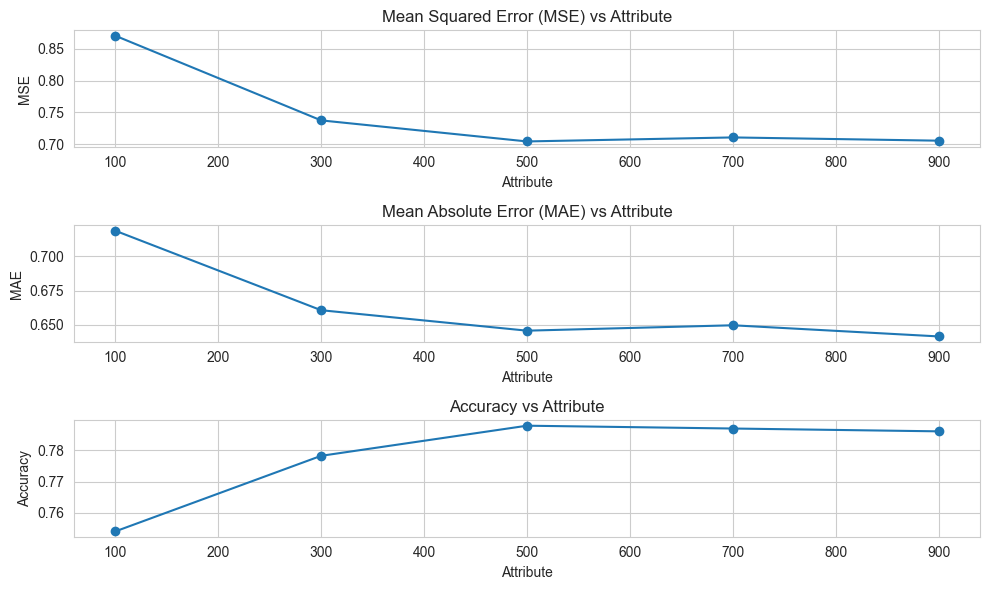

In [1]:
import matplotlib.pyplot as plt

# Data
attributes = [100, 300, 500, 700, 900]
mse_values = [0.8709787068254514, 0.7373011594182215, 0.7040590543653152, 0.7103933803964357, 0.7052506790672214]
mae_values = [0.718844228738666, 0.6606363015609624, 0.6456593853695873, 0.6496066713598331, 0.6414389084899733]
accuracy_values = [0.7541, 0.7782, 0.7878, 0.7869, 0.786]

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(attributes, mse_values, marker='o')
plt.title('Mean Squared Error (MSE) vs Attribute')
plt.xlabel('Attribute')
plt.ylabel('MSE')

plt.subplot(3, 1, 2)
plt.plot(attributes, mae_values, marker='o')
plt.title('Mean Absolute Error (MAE) vs Attribute')
plt.xlabel('Attribute')
plt.ylabel('MAE')

plt.subplot(3, 1, 3)
plt.plot(attributes, accuracy_values, marker='o')
plt.title('Accuracy vs Attribute')
plt.xlabel('Attribute')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
